# Spin Boson Model Examples

### Mean Field calculations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation # import simulation class 
from qc_lab.models import SpinBoson # import model class 
from qc_lab.algorithms import MeanField # import algorithm class 
from qc_lab.dynamics import serial_driver # import dynamics driver

/home/akrotz/Research/qc_lab-dev/qc_lab/ingredients.py:253: DeprecationWarning: invalid escape sequence '\s'
  """
/home/akrotz/Research/qc_lab-dev/qc_lab/ingredients.py:533: DeprecationWarning: invalid escape sequence '\d'
  """


100%|██████████| 3001/3001 [00:01<00:00, 1802.06it/s]


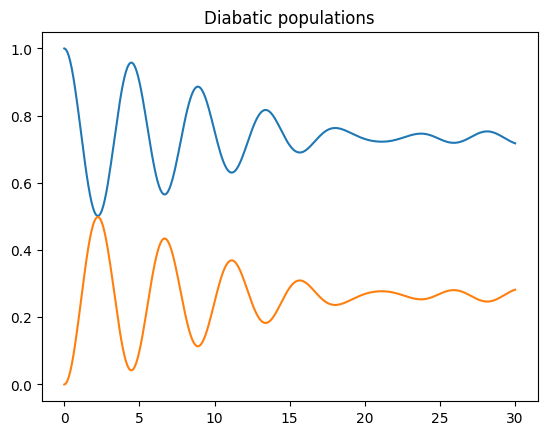

In [2]:
sim = Simulation()

sim.settings.num_trajs = 200
sim.settings.batch_size = 50
sim.settings.tmax = 30
sim.settings.dt_update = 0.01

sim.model = SpinBoson({
    'V':0.5,
    'E':0.5,
    'A':100,
    'W':0.1,
    'l_reorg':0.005,
    'boson_mass':1.0,
    'kBT':1.0,
})
sim.algorithm = MeanField()

sim.state.wf_db= np.array([1,0], dtype=complex)

data = serial_driver(sim)

t = data.data_dict['t']
plt.plot(t, np.real(np.einsum('tii->ti',data.data_dict['dm_db'])))
plt.title('Diabatic populations')
plt.show()

### Surface Hopping Calculations

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation # import simulation class 
from qc_lab.models import SpinBoson # import model class 
from qc_lab.algorithms import FewestSwitchesSurfaceHopping # import algorithm class 
from qc_lab.dynamics import serial_driver # import dynamics driver

#### Stochastic sampling

100%|██████████| 3001/3001 [00:03<00:00, 976.20it/s]


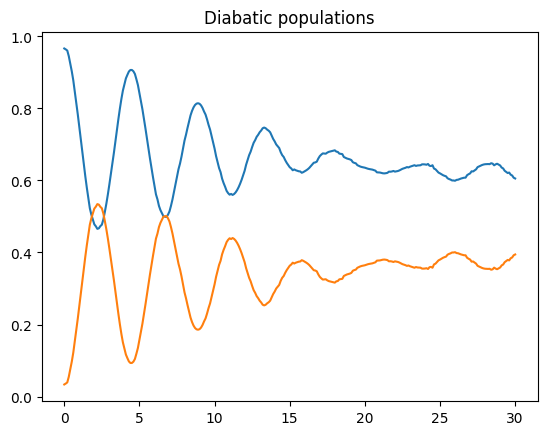

In [4]:
sim = Simulation()

sim.settings.num_trajs = 200
sim.settings.batch_size = 50
sim.settings.tmax = 30
sim.settings.dt_update = 0.01

sim.model = SpinBoson({
    'V':0.5,
    'E':0.5,
    'A':100,
    'W':0.1,
    'l_reorg':0.005,
    'boson_mass':1.0,
    'kBT':1.0,

})
sim.algorithm = FewestSwitchesSurfaceHopping({
    'fssh_deterministic':False,
    'gauge_fixing':'sign_overlap',
})

sim.state.wf_db= np.array([1,0], dtype=complex)

data = serial_driver(sim)

t = data.data_dict['t']
plt.plot(t, np.real(np.einsum('tii->ti',data.data_dict['dm_db'])))
plt.title('Diabatic populations')
plt.show()

#### Deterministic sampling

To use deterministic sampling we multiply the number of trajectories and batch size by the number of states. Note that the convergence behavior changes.

100%|██████████| 3001/3001 [00:05<00:00, 571.09it/s]


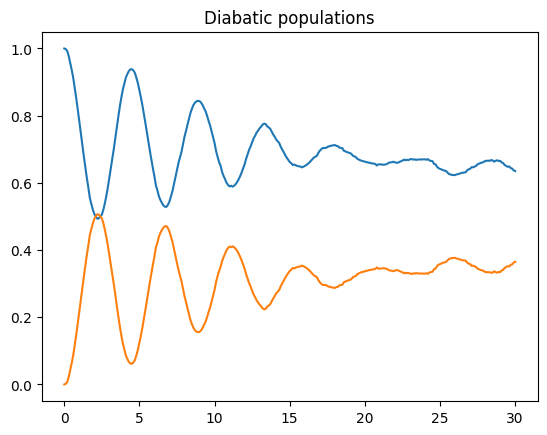

In [5]:
sim = Simulation()

sim.settings.num_trajs = 200*2
sim.settings.batch_size = 50*2
sim.settings.tmax = 30
sim.settings.dt_update = 0.01

sim.model = SpinBoson({
    'V':0.5,
    'E':0.5,
    'A':100,
    'W':0.1,
    'l_reorg':0.005,
    'boson_mass':1.0,
    'kBT':1.0,

})
sim.algorithm = FewestSwitchesSurfaceHopping({
    'fssh_deterministic':True,
    'gauge_fixing':'sign_overlap',
})

sim.state.wf_db= np.array([1,0], dtype=complex)

data = serial_driver(sim)

t = data.data_dict['t']
plt.plot(t, np.real(np.einsum('tii->ti',data.data_dict['dm_db'])))
plt.title('Diabatic populations')
plt.show()

### Using a parllel driver

We will parallelize the above deterministic surface hopping calculation over four tasks.

100%|██████████| 3001/3001 [00:07<00:00, 378.30it/s]


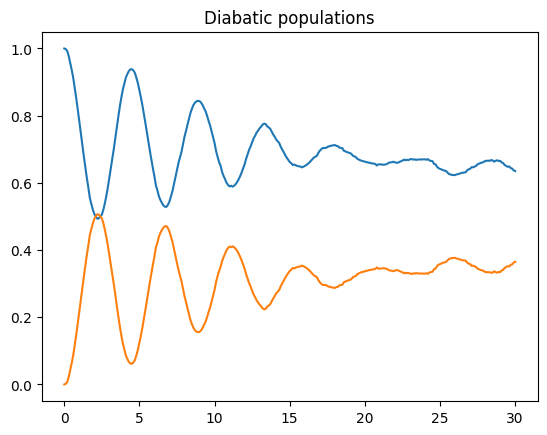

In [6]:
from qc_lab.dynamics import parallel_driver_multiprocessing # import dynamics driver

sim = Simulation()

sim.settings.num_trajs = 200*2
sim.settings.batch_size = 50*2
sim.settings.tmax = 30
sim.settings.dt_update = 0.01

sim.model = SpinBoson({
    'V':0.5,
    'E':0.5,
    'A':100,
    'W':0.1,
    'l_reorg':0.005,
    'boson_mass':1.0,
    'kBT':1.0,

})
sim.algorithm = FewestSwitchesSurfaceHopping({
    'fssh_deterministic':True,
    'gauge_fixing':'sign_overlap',
})

sim.state.wf_db= np.array([1,0], dtype=complex)

data = parallel_driver_multiprocessing(sim)

t = data.data_dict['t']
plt.plot(t, np.real(np.einsum('tii->ti',data.data_dict['dm_db'])))
plt.title('Diabatic populations')
plt.show()